# Explore an HCA data set in Scanpy
This notebook shows a few quick steps to start exploring HCA data sets using [scanpy](https://github.com/theislab/scanpy) ([citation](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0)).


In [16]:
%matplotlib inline

import loompy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='brg')
sc.logging.print_versions()
results_file = './write/pancreas.h5ad'

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Read the expression matrix file downloaded from the HCA
The file shown here is from the study [Single-Cell Analysis of Human Pancreas Reveals Transcriptional Signatures of Aging and Somatic Mutation Patterns by Enge, et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6047899/), available in this repository at `./pancreas.loom`

In [4]:
adata = sc.read_loom(
    'pancreas.loom', sparse=True, cleanup=False, X_name='spliced', obs_names='CellID', var_names='Gene')

## Filter and normalize
Here we go through several steps to clean up the data:
- Filter out genes that are present in few cells, cells that contain few genes
- Transform the sum of (remaining) gene expression counts in each cell to equal the same number (1e4)
- Keep 500 highest expressed genes (this threshold used in initial publication)

In [5]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=250)
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1

dat = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)
dat.var['mean_percent'] = dat.X.mean(axis=0).A1
top = dat.var.sort_values('mean_percent', ascending=False).index[:500]
adata = adata[:, top]

filtered out 26338 genes that are detected in less than 5 cells


## Perform dimensionality reduction and clustering
- Compute the principal components
- Generate the neighborhood graph
- Determine clusters using Louvain method
- Perform dimensionality reduction with UMAP
- Perform dimensionality reduction with tSNE

In [11]:
sc.pp.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.louvain(adata, resolution=0.1)
sc.tl.tsne(adata)
sc.tl.umap(adata)
adata.write(results_file)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.63) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.14) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:49.78) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    finished (0:00:04.23) --> added
    'X_umap', UMAP coordinates (adata.obsm)


## Embed cells using tSNE

The example used in this notebook is a study of pancreas cells. Below, clusters are plotted alongside three genes that are known to mark different pancreas cell types.
HCA uses Gencode nomenclature as gene identifiers. A list of these identifiers and their corresponding gene names is included in the repository with this notebook. 

Shown below:
- GCG: ENSG00000115263.14
- INS: ENSG00000254647.6
- PRSS1: ENSG00000204983.13

Feel free to try these and others on your own
- PPY: ENSG00000108849.7
- SST: ENSG00000157005.3

Other possible marker genes were filtered out in the preprocessing steps above (e.g. PROM1 and THY1).

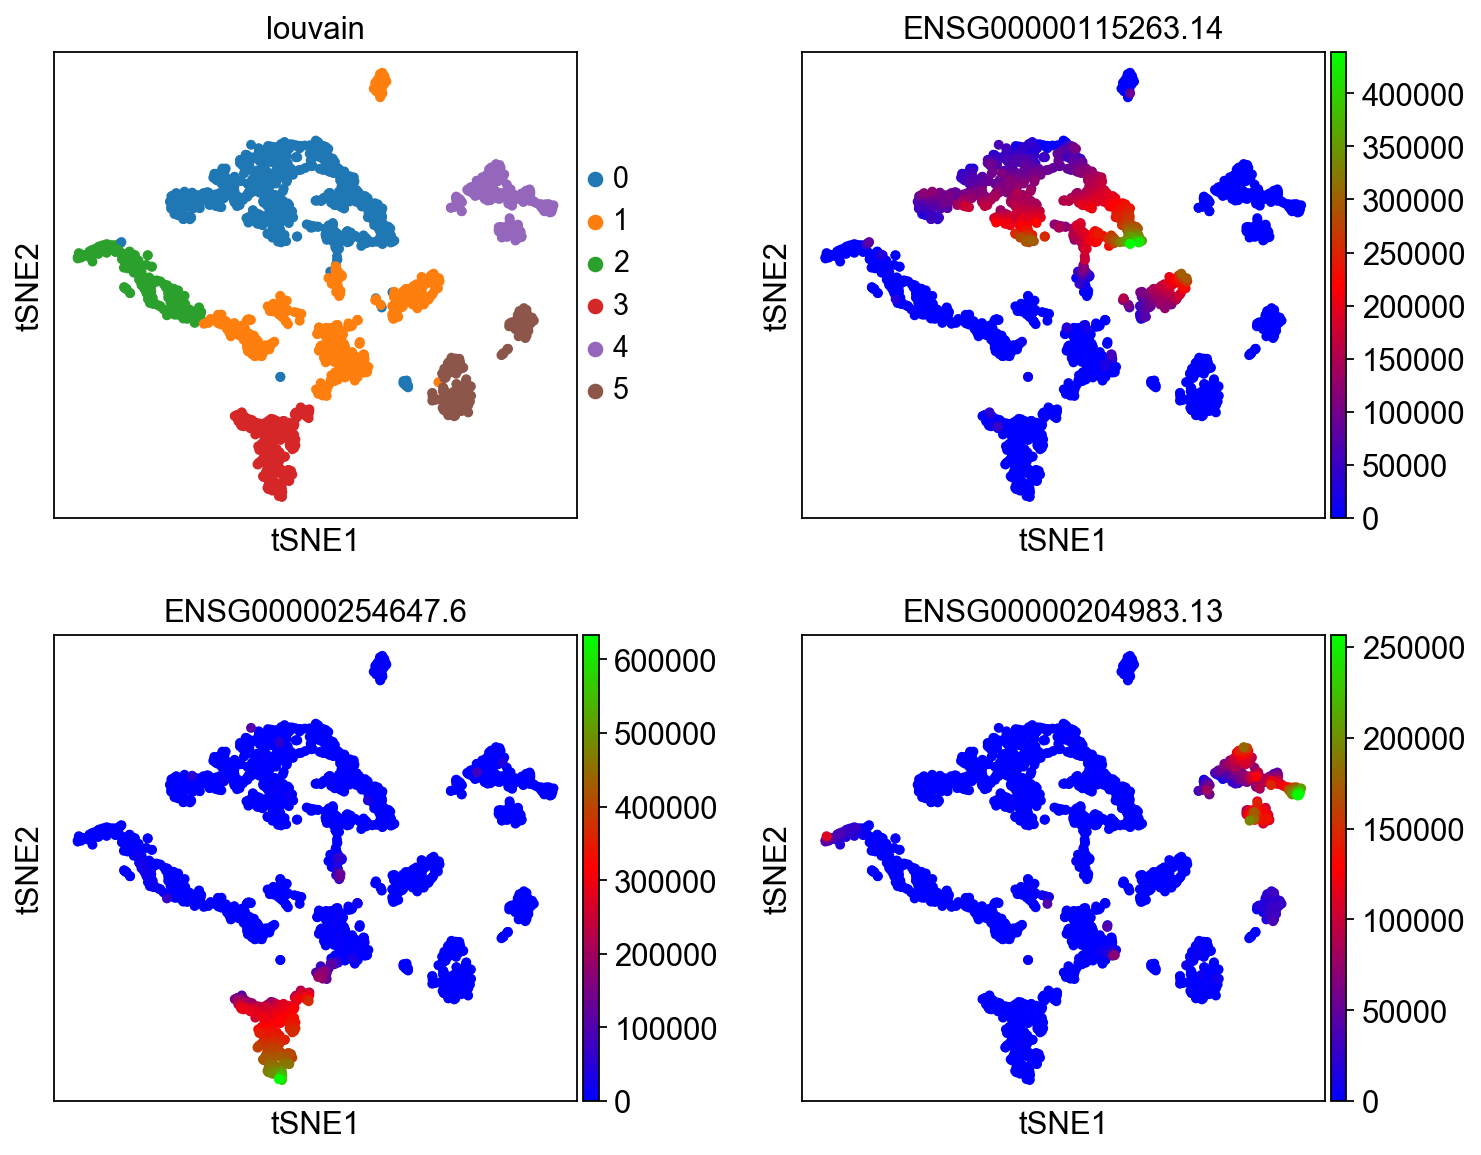

<Figure size 320x320 with 0 Axes>

In [24]:
sc.pl.tsne(adata, color=['louvain', 'ENSG00000115263.14', 'ENSG00000254647.6', 'ENSG00000204983.13'], ncols=2, wspace=0.3)
plt.tight_layout();

## Embed cells using UMAP

The same clusters and markers can be viewed using alternative embeddings:

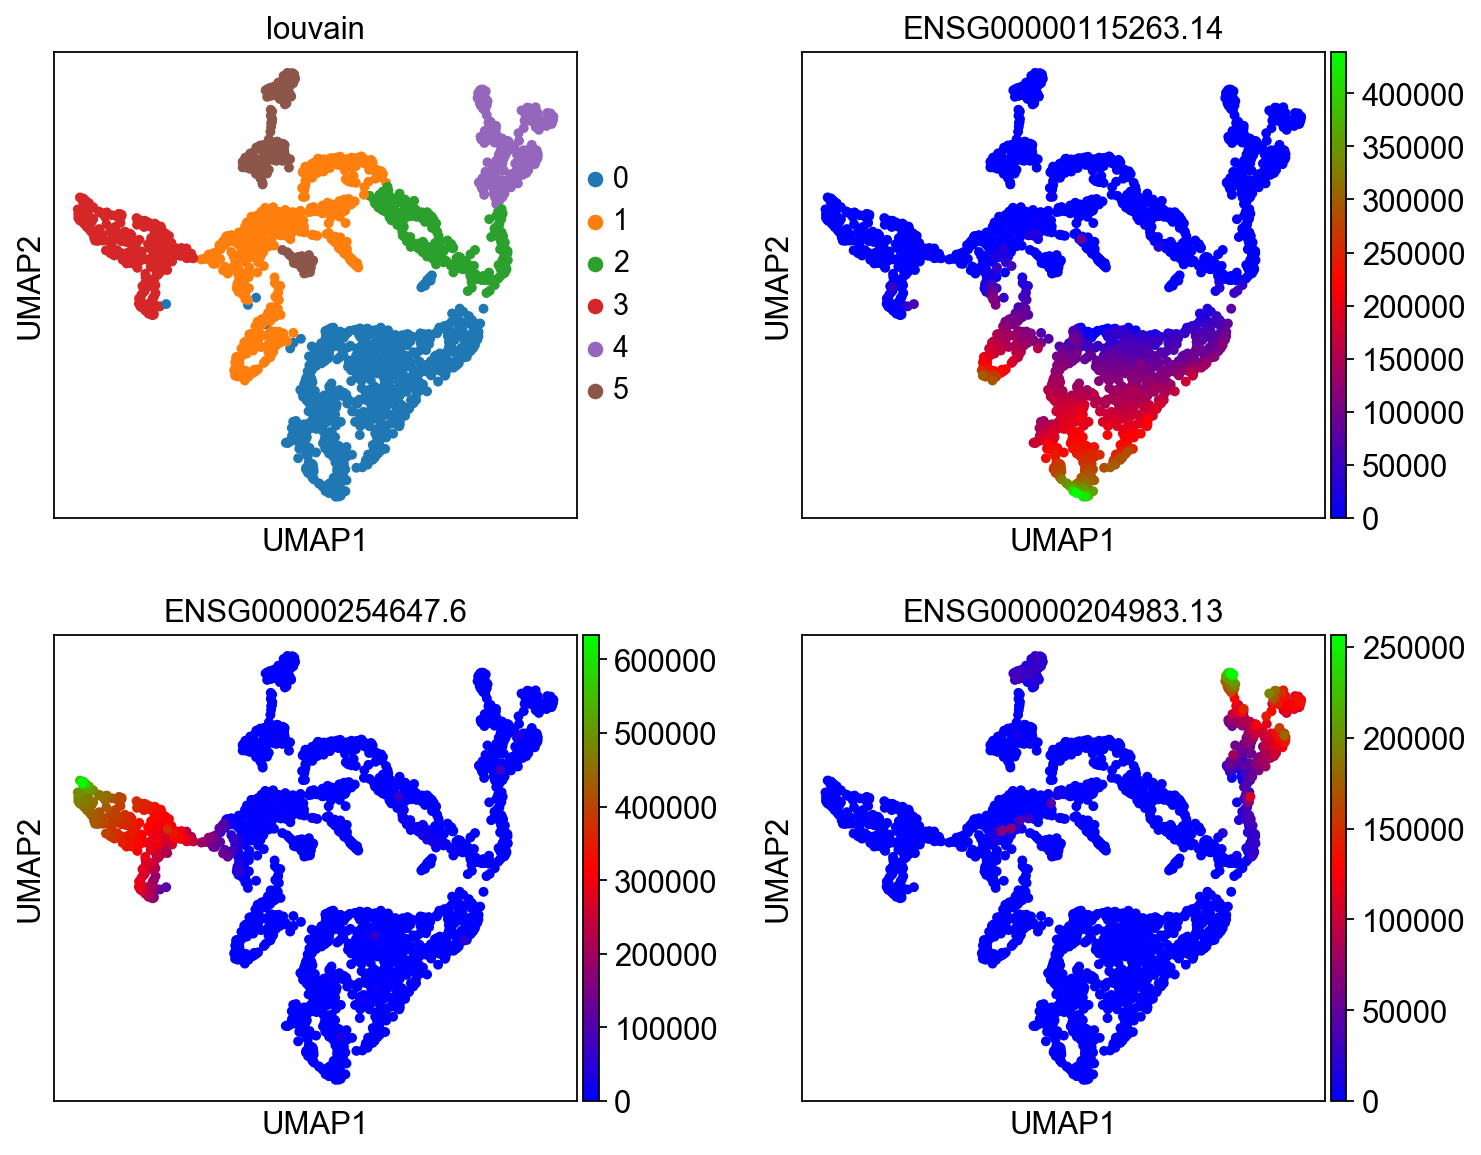

<Figure size 320x320 with 0 Axes>

In [25]:
sc.pl.umap(adata, color=['louvain', 'ENSG00000115263.14', 'ENSG00000254647.6', 'ENSG00000204983.13'], ncols=2, wspace=0.3)
plt.tight_layout();

## Where to go from here
There are many more ways to explore the data you've downloaded from the HCA -- see the scanpy tutorials for ideas https://scanpy.readthedocs.io/en/latest/examples.html#